In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import os, random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re

from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import class_weight

# import tensorflow as tf
# from tensorflow import keras
# from keras.utils import to_categorical

seed = 42
plt.rc('font', size=8)
# plt.rc('axes', titlesize=8)
# gpus = tf.config.experimental.list_physical_devices('GPU')
# for gpu in gpus:
#     tf.config.experimental.set_memory_growth(gpu, True)

In [2]:
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    # tf.random.set_seed(seed)
    # tf.keras.utils.set_random_seed(seed)
    # tf.config.experimental.enable_op_determinism()

seed_everything(seed)

# Data inspection & selection
Load the dataset and look inside it

In [108]:
data = pd.read_parquet("data/job_table.parquet")
data.head(10)

,pn_min_cpus,resize_time,ntasks_per_socket,tres_freq,comment,ntasks_per_socket_str,std_in,array_task_throttle,max_nodes,contiguous,...,cpus_allocated,billable_tres,last_sched_eval,eligible_time,power_flags,cores_per_socket,sockets_per_node,shared,cpus_per_task,req_nodes
0,4,1970-01-01 01:00:00+00:00,,,,UNLIMITED,/dev/null,,0,False,...,{'r245n04': 4},4.0,2020-05-22T01:07:00.000Z,2020-05-22 01:06:05+00:00,0,,,OK,4,['r245n04']
1,4,1970-01-01 01:00:00+00:00,,,,UNLIMITED,/dev/null,,0,False,...,{'r250n19': 4},4.0,2020-05-22T01:07:00.000Z,2020-05-22 01:06:10+00:00,0,,,OK,4,['r250n19']
2,32,1970-01-01 01:00:00+00:00,,,,UNLIMITED,/dev/null,,0,False,...,"{'r212n10': 32, 'r212n15': 32, 'r212n14': 32, ...",256.0,2020-05-22T09:28:37.000Z,2020-05-22 09:28:37+00:00,0,,,OK,1,
3,4,1970-01-01 01:00:00+00:00,,,,UNLIMITED,/dev/null,,0,False,...,{'r209n15': 4},4.0,2020-05-22T20:39:06.000Z,2020-05-22 01:05:39+00:00,0,,,OK,4,['r209n15']
4,256,1970-01-01 01:00:00+00:00,2.0,,,2,/dev/null,,1,False,...,,,2020-05-22T18:56:39.000Z,2020-05-22 18:56:39+00:00,0,,,OK,32,
5,4,1970-01-01 01:00:00+00:00,,,,UNLIMITED,/dev/null,,0,False,...,{'r245n14': 4},4.0,2020-05-22T01:07:00.000Z,2020-05-22 01:06:06+00:00,0,,,OK,4,['r245n14']
6,1,1970-01-01 01:00:00+00:00,,,,UNLIMITED,/dev/null,,0,False,...,{'r226n11': 4},4.0,2020-05-22T10:41:04.000Z,2020-05-22 10:28:50+00:00,0,,,OK,1,['r226n11']
7,1,1970-01-01 01:00:00+00:00,,,,UNLIMITED,/dev/null,,0,False,...,{'r245n20': 4},4.0,2020-05-22T14:28:26.000Z,2020-05-22 10:29:02+00:00,0,,,OK,1,['r245n20']
8,4,1970-01-01 01:00:00+00:00,1.0,,,1,/dev/null,,0,False,...,{'r239n19': 4},4.0,2020-05-22T16:12:29.000Z,2020-05-22 16:12:28+00:00,0,,,OK,4,
9,128,1970-01-01 01:00:00+00:00,2.0,,,2,/dev/null,,0,False,...,{'r239n20': 128},128.0,2020-05-22T12:15:20.000Z,2020-05-22 12:15:19+00:00,0,,,OK,32,


In [5]:
print(f"Number of rows: {len(data)}")
print(f"Number of columns: {len(data.columns)}")
print(data.columns)

Number of rows: 6236346
Number of columns: 100
Index(['pn_min_cpus', 'resize_time', 'ntasks_per_socket', 'tres_freq',
       'comment', 'ntasks_per_socket_str', 'std_in', 'array_task_throttle',
       'max_nodes', 'contiguous', 'max_cpus', 'resv_name', 'user_id',
       'tres_per_task', 'derived_ec', 'tres_per_socket', 'exc_nodes',
       'tres_req_str', 'array_job_id', 'boards_per_node', 'priority',
       'num_nodes', 'tres_per_node', 'cpus_alloc_layout', 'name',
       'run_time_str', 'array_task_str', 'time_min', 'time_limit_str',
       'end_time', 'year_month', 'alloc_sid', 'mem_per_cpu', 'req_switch',
       'show_flags', 'group_id', 'wait4switch', 'array_task_id', 'exit_code',
       'mem_per_node', 'restart_cnt', 'requeue', 'tres_bind', 'profile',
       'batch_flag', 'plugin', 'work_dir', 'pn_min_memory', 'nice',
       'ntasks_per_node', 'ntasks_per_core_str', 'accrue_time',
       'tres_alloc_str', 'nodes', 'sockets_per_board', 'std_out',
       'array_max_tasks', 'job_id',

Since, the dataset contains a huge set of information, we decided to use only a smal subset of it. In particular, for the early stage of our work, we use submit time features. So, we have only data that have the string *tres_req_str* present (by which cpu,gpu,mem,ecc are rquested) and the toehr features avaliable at request time(requested by the submitter).

We only consider job that are in one of the possible states: COMPLETED, FAILED, OUT_OF_MEMORY, TIMEOUT

In [109]:
columns = ["submit_time", "user_id", "group_id", "name", "command", "partition", "priority",
           "qos", "time_limit", "cpus_per_task", 'num_tasks', "tres_req_str", "job_state"]

# ["cpus_per_tres", "num_cpus", "num_nodes", "ntasks_per_socket", "req_nodes"]

df = data[columns]
df = df[df.tres_req_str != ""]
df = df[(df.job_state != "CANCELLED") & (df.job_state != "NODE_FAIL")]
df.reset_index(drop=True, inplace=True)
df

,submit_time,user_id,group_id,name,command,partition,priority,qos,time_limit,cpus_per_task,num_tasks,tres_req_str,job_state
0,2020-05-22 01:06:05+00:00,32171,25200,slurm_multinode_prova,/m100_scratch/userinternal/nshukla1/stream_CPU...,m100_usr_prod,87034,normal,10,4,1,"cpu=4,mem=246000M,node=1,billing=4",COMPLETED
1,2020-05-22 01:06:10+00:00,32171,25200,slurm_multinode_prova,/m100_scratch/userinternal/nshukla1/stream_CPU...,m100_usr_prod,85884,normal,10,4,1,"cpu=4,mem=246000M,node=1,billing=4",COMPLETED
2,2020-05-22 01:05:39+00:00,32171,25200,slurm_multinode_prova,/m100_scratch/userinternal/nshukla1/stream_CPU...,m100_usr_prod,115982,normal,10,4,1,"cpu=4,mem=246000M,node=1,billing=4",COMPLETED
3,2020-05-22 18:56:39+00:00,32152,25200,CBC,/m100_scratch/userexternal/squlagha/CaB3C3/job...,m100_usr_prod,80216,normal,360,32,8,"cpu=256,mem=230000M,node=1,billing=256,gres/gpu=1",FAILED
4,2020-05-22 01:06:06+00:00,32171,25200,slurm_multinode_prova,/m100_scratch/userinternal/nshukla1/stream_CPU...,m100_usr_prod,86934,normal,10,4,1,"cpu=4,mem=246000M,node=1,billing=4",COMPLETED
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016525,2020-10-08 20:31:23+00:00,32588,25200,sire_pjc,/m100_work/hpce3_Tosco/WANG_FULL_OFF_121/RERUN...,m100_usr_prod,297707,normal,720,1,4,"cpu=4,mem=8000M,node=1,billing=4,gres/gpu=1",COMPLETED
1016526,2020-10-09 05:18:51+00:00,31392,25200,praAnt-run4-2m,/m100_work/IscrB_INwARDS_0/NR/NR3/PRant-Run4/r...,m100_usr_prod,145536,normal,1440,32,4,"cpu=128,mem=237.50G,node=1,billing=128,gres/gpu=4",COMPLETED
1016527,2020-10-09 10:20:40+00:00,26429,25200,job_density.sh,/m100_scratch/userexternal/mfarnesi/CP2K_Inter...,m100_usr_prod,917,qos_lowprio,60,32,4,"cpu=128,mem=230000M,node=1,billing=128,gres/gpu=4",FAILED
1016528,2020-10-09 01:36:42+00:00,32232,25200,script.marconi100.x,/m100/home/userexternal/nthomopu/script.marcon...,m100_usr_prod,330946,normal,10,1,8,"cpu=8,mem=7100M,node=1,billing=8,gres/gpu=1",COMPLETED


Print number of  missing values per columns..

In [9]:
df = df.replace('', np.nan)
print(df.isna().sum())
prev_len = len(df)
print(f"Num of rows: {len(df)}")

submit_time          0
user_id              0
group_id             0
name                 0
command           3584
partition            0
priority             0
qos                  0
time_limit           0
cpus_per_task        0
num_tasks        37945
tres_req_str         0
job_state            0
dtype: int64
Num of rows: 1016530


The presence of nan values in thi subset is not too much. In order to avoid problem after, drop all the rows that contains at leat a nan values.

In [12]:
df = df.dropna().reset_index(drop=True)
print(df.isna().sum())
print(f"Num of rows: {len(df)}")
print(f"Dropped rows: {prev_len - len(df)} ({(1-(len(df)/prev_len)):.1%})")

submit_time      0
user_id          0
group_id         0
name             0
command          0
partition        0
priority         0
qos              0
time_limit       0
cpus_per_task    0
num_tasks        0
tres_req_str     0
job_state        0
dtype: int64
Num of rows: 975170
Dropped rows: 41360 (4.1%)


Set time zone to None, bacuse we are not interested in it. At the end, store the subset for the future.

In [13]:
df["submit_time"] = df["submit_time"].dt.tz_localize(None)
df.to_pickle("data/job_table_reduced.pkl")
del data 
del df

## Data Analysis

In [24]:
df =pd.read_pickle("data/job_table_reduced.pkl")
df.head()

,submit_time,user_id,group_id,name,command,partition,priority,qos,time_limit,cpus_per_task,num_tasks,tres_req_str,job_state
0,2020-05-22 01:06:05,32171,25200,slurm_multinode_prova,/m100_scratch/userinternal/nshukla1/stream_CPU...,m100_usr_prod,87034,normal,10,4,1,"cpu=4,mem=246000M,node=1,billing=4",COMPLETED
1,2020-05-22 01:06:10,32171,25200,slurm_multinode_prova,/m100_scratch/userinternal/nshukla1/stream_CPU...,m100_usr_prod,85884,normal,10,4,1,"cpu=4,mem=246000M,node=1,billing=4",COMPLETED
2,2020-05-22 01:05:39,32171,25200,slurm_multinode_prova,/m100_scratch/userinternal/nshukla1/stream_CPU...,m100_usr_prod,115982,normal,10,4,1,"cpu=4,mem=246000M,node=1,billing=4",COMPLETED
3,2020-05-22 18:56:39,32152,25200,CBC,/m100_scratch/userexternal/squlagha/CaB3C3/job...,m100_usr_prod,80216,normal,360,32,8,"cpu=256,mem=230000M,node=1,billing=256,gres/gpu=1",FAILED
4,2020-05-22 01:06:06,32171,25200,slurm_multinode_prova,/m100_scratch/userinternal/nshukla1/stream_CPU...,m100_usr_prod,86934,normal,10,4,1,"cpu=4,mem=246000M,node=1,billing=4",COMPLETED


As you can see from above table, not all the faetures are numeric, but there are a lot of text data. This type of date don't suit very well for learning algorithm, so fix it.

Start with those data types that are text, convert it into a number.

In [25]:
text_columns = ["name", "command", "partition", "qos"]
ord_enc =  OrdinalEncoder(dtype=np.int64)
for col in text_columns:
    val = df[col].values.reshape(-1, 1)
    df[col] = ord_enc.fit_transform(val)
print(f"Text columns transformed: {text_columns}")

df[df.columns[1:-2]] = df[df.columns[1:-2]].apply(pd.to_numeric)

df.head()

Text columns transformed: ['name', 'command', 'partition', 'qos']


,submit_time,user_id,group_id,name,command,partition,priority,qos,time_limit,cpus_per_task,num_tasks,tres_req_str,job_state
0,2020-05-22 01:06:05,32171,25200,77949,62668,3,87034,4,10,4,1,"cpu=4,mem=246000M,node=1,billing=4",COMPLETED
1,2020-05-22 01:06:10,32171,25200,77949,62782,3,85884,4,10,4,1,"cpu=4,mem=246000M,node=1,billing=4",COMPLETED
2,2020-05-22 01:05:39,32171,25200,77949,62085,3,115982,4,10,4,1,"cpu=4,mem=246000M,node=1,billing=4",COMPLETED
3,2020-05-22 18:56:39,32152,25200,30918,51406,3,80216,4,360,32,8,"cpu=256,mem=230000M,node=1,billing=256,gres/gpu=1",FAILED
4,2020-05-22 01:06:06,32171,25200,77949,62678,3,86934,4,10,4,1,"cpu=4,mem=246000M,node=1,billing=4",COMPLETED


Now, for the *tres_req_str* we decide to split this column into 5 different columns

In [26]:
labels = df.pop("job_state")

fields = ["req_cpu", "req_mem", "req_node", "req_billing", "req_gpu"]
req_str = df.pop('tres_req_str')
df[fields] = req_str.str.split(',', n=5, expand=True)
for f in fields:
    df[f] = df[f].apply(lambda c: re.sub("[a-zA-Z=/]", "", c) if c is not None else 0)
    
df[fields] = df[fields].apply(pd.to_numeric)   
    
df["job_state"] = labels.astype(str)

df.head()

,submit_time,user_id,group_id,name,command,partition,priority,qos,time_limit,cpus_per_task,num_tasks,req_cpu,req_mem,req_node,req_billing,req_gpu,job_state
0,2020-05-22 01:06:05,32171,25200,77949,62668,3,87034,4,10,4,1,4,246000.0,1,4,0,COMPLETED
1,2020-05-22 01:06:10,32171,25200,77949,62782,3,85884,4,10,4,1,4,246000.0,1,4,0,COMPLETED
2,2020-05-22 01:05:39,32171,25200,77949,62085,3,115982,4,10,4,1,4,246000.0,1,4,0,COMPLETED
3,2020-05-22 18:56:39,32152,25200,30918,51406,3,80216,4,360,32,8,256,230000.0,1,256,1,FAILED
4,2020-05-22 01:06:06,32171,25200,77949,62678,3,86934,4,10,4,1,4,246000.0,1,4,0,COMPLETED


Last column to preprocess is *submit_time*. For this column, we will use the proleptic Gregorian ordinal, so the count from the the day 1 of the month 1 of th year 1.

In [27]:
df["submit_time"] = df["submit_time"].apply(lambda c: c.toordinal())
df.head(5)

,submit_time,user_id,group_id,name,command,partition,priority,qos,time_limit,cpus_per_task,num_tasks,req_cpu,req_mem,req_node,req_billing,req_gpu,job_state
0,737567,32171,25200,77949,62668,3,87034,4,10,4,1,4,246000.0,1,4,0,COMPLETED
1,737567,32171,25200,77949,62782,3,85884,4,10,4,1,4,246000.0,1,4,0,COMPLETED
2,737567,32171,25200,77949,62085,3,115982,4,10,4,1,4,246000.0,1,4,0,COMPLETED
3,737567,32152,25200,30918,51406,3,80216,4,360,32,8,256,230000.0,1,256,1,FAILED
4,737567,32171,25200,77949,62678,3,86934,4,10,4,1,4,246000.0,1,4,0,COMPLETED


Save the data for the future.

In [28]:
df.to_pickle("data/job_table_preproc.pkl")
del df

## Data Anlaysis

In [29]:
df = pd.read_pickle("data/job_table_preproc.pkl")
df.head()

,submit_time,user_id,group_id,name,command,partition,priority,qos,time_limit,cpus_per_task,num_tasks,req_cpu,req_mem,req_node,req_billing,req_gpu,job_state
0,737567,32171,25200,77949,62668,3,87034,4,10,4,1,4,246000.0,1,4,0,COMPLETED
1,737567,32171,25200,77949,62782,3,85884,4,10,4,1,4,246000.0,1,4,0,COMPLETED
2,737567,32171,25200,77949,62085,3,115982,4,10,4,1,4,246000.0,1,4,0,COMPLETED
3,737567,32152,25200,30918,51406,3,80216,4,360,32,8,256,230000.0,1,256,1,FAILED
4,737567,32171,25200,77949,62678,3,86934,4,10,4,1,4,246000.0,1,4,0,COMPLETED


Print some statistics

In [34]:
numeric_features = ["time_limit", "cpus_per_task", "num_tasks", "req_cpu",
                     "req_mem", "req_node", "req_billing", "req_gpu"]

df[numeric_features].describe().T

,count,mean,std,min,25%,50%,75%,max
time_limit,975170.0,1063.603737,511.217883,1.0,720.0,1440.0,1440.0,1440.0
cpus_per_task,975170.0,13.301554,16.250140,1.0,1.0,2.0,32.0,4444.0
num_tasks,975170.0,16.523853,160.926988,0.0,4.0,4.0,24.0,32768.0
req_cpu,975170.0,114.862959,621.956853,1.0,4.0,24.0,128.0,65536.0
req_mem,975170.0,98244.121300,534760.600495,1.0,237.5,8000.0,86000.0,57960000.0
req_node,975170.0,1.724648,7.200674,1.0,1.0,1.0,1.0,256.0
req_billing,975170.0,114.862959,621.956853,1.0,4.0,24.0,128.0,65536.0
req_gpu,975170.0,4.596272,27.519665,0.0,0.0,1.0,4.0,1024.0


From the above statistics, we can highlight:
1. data are neither normalized nor standardized
2. for all the requested feature, we saw a max value way grater than the mean value ann the 50%, it means the presence of outliers.
3. 

job_state
COMPLETED        0.879829
FAILED           0.101628
TIMEOUT          0.014265
OUT_OF_MEMORY    0.004277
Name: proportion, dtype: float64


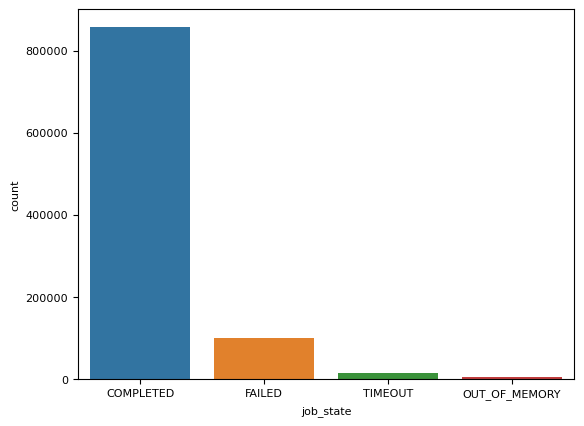

In [31]:
sns.countplot(x=df["job_state"])
print(df.job_state.value_counts(normalize=True))

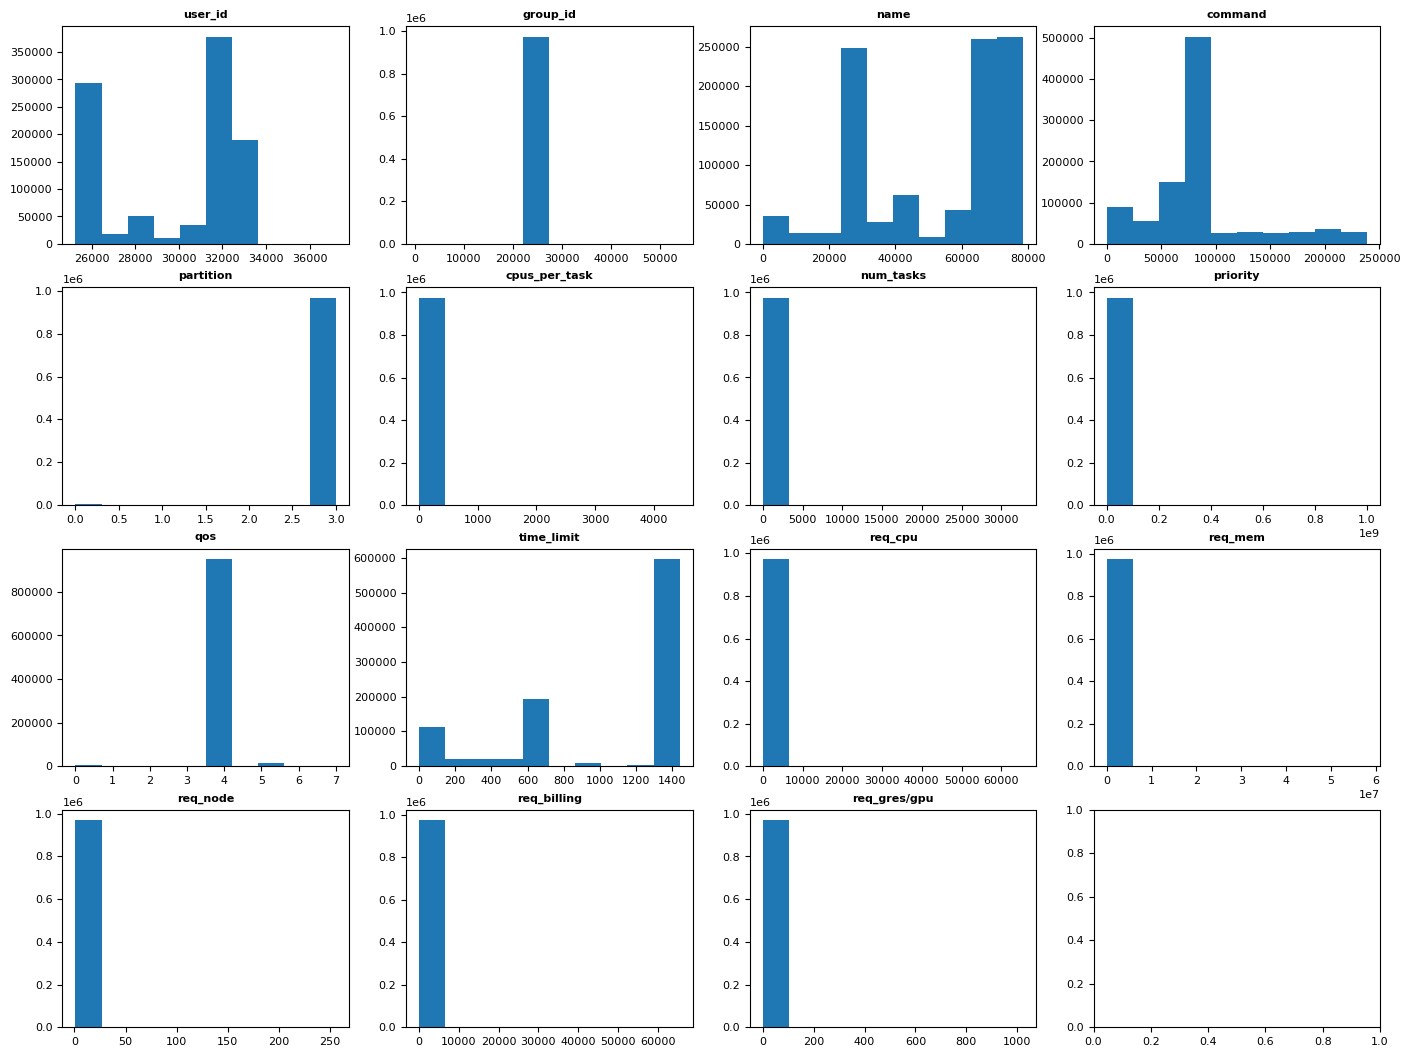

In [25]:
cols = df.select_dtypes(include="int64").columns
fig, axs = plt.subplots(4, 4, figsize=(17, 13))
i, j = 0, 0
for col in cols:
    axs[i, j].hist(df[col])
    axs[i, j].set_title(col, fontweight="bold")
    j+=1
    if j%4 == 0:
        j = 0
        i +=1

In [26]:
res = dict(df.req_cpu.value_counts())
print(res)

{128: 306694, 4: 209649, 24: 196635, 16: 69015, 1: 44801, 32: 41583, 64: 33498, 256: 17891, 2: 8536, 2048: 7736, 512: 6921, 8: 6691, 1024: 4082, 1280: 2158, 384: 2109, 1152: 1603, 4096: 1398, 192: 1275, 96: 1091, 48: 1008, 640: 974, 768: 838, 12: 825, 40: 654, 1920: 608, 6: 508, 36: 439, 20: 439, 30: 417, 72: 388, 18: 362, 16384: 355, 2560: 274, 5: 256, 7: 237, 8192: 231, 1536: 220, 896: 195, 80: 184, 3200: 168, 1792: 145, 6144: 130, 6400: 122, 32768: 112, 3072: 108, 5120: 102, 160: 100, 832: 80, 7680: 60, 90: 58, 3: 57, 4608: 56, 16128: 55, 320: 53, 576: 49, 28: 49, 10: 48, 2304: 46, 60: 45, 33: 41, 3840: 40, 120: 36, 180: 36, 66: 32, 1664: 32, 400: 31, 56: 26, 15: 23, 9: 23, 144: 23, 288: 21, 480: 19, 9216: 18, 13824: 18, 864: 15, 1408: 14, 18432: 14, 99: 14, 32256: 14, 100: 13, 3584: 12, 960: 11, 12800: 11, 14336: 11, 10240: 11, 1296: 10, 132: 10, 504: 10, 224: 9, 240: 9, 8320: 8, 129: 7, 6912: 6, 360: 6, 216: 5, 16000: 5, 14: 5, 27: 5, 8960: 5, 252: 4, 12288: 4, 6016: 3, 20480: 3, 

In [27]:
sns.countplot(x=df[""])
print(len(df.req_cpu.unique()))
print(df.req_cpu.value_counts(normalize=True))

KeyError: ''

<Axes: >

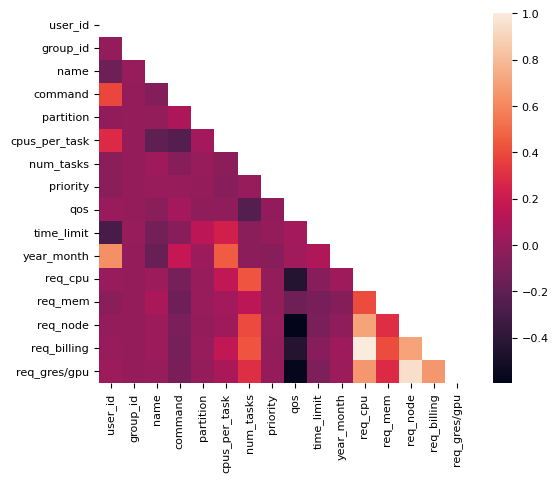

In [ ]:
df_corr = df.drop(["job_state", "submit_time"], axis=1)
corr_matrix=df_corr.corr()
mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr_matrix, mask=mask, square=True)

Inspect unique column values to better understand how it's usefull for exit status detection. Now we only consider binary case for semplicity were job are or Completed or Failed

In [ ]:
df_bin = df.drop(["submit_time"], axis=1)
df_bin["job_state"] = df_bin["job_state"].replace({"OUT_OF_MEMORY": "FAILED", "TIMEOUT": "FAILED"})
df_bin["job_state"] = df_bin["job_state"].replace({"COMPLETED": 0, "FAILED": 1}).astype(np.int64)

for col in df_bin.select_dtypes(include="int").columns:
    print(f"{col} unique values: {len(df_bin[col].unique())}")

user_id unique values: 510
group_id unique values: 6
name unique values: 78586
command unique values: 238768
partition unique values: 4
cpus_per_task unique values: 34
num_tasks unique values: 115
priority unique values: 86357
qos unique values: 8
time_limit unique values: 355
year_month unique values: 6
req_cpu unique values: 156
req_mem unique values: 505
req_node unique values: 62
req_billing unique values: 156
req_gres/gpu unique values: 71
job_state unique values: 2


Now excluding *command* feature which has to much unique values, plot hist plot

<Axes: xlabel='req_gres/gpu', ylabel='Count'>

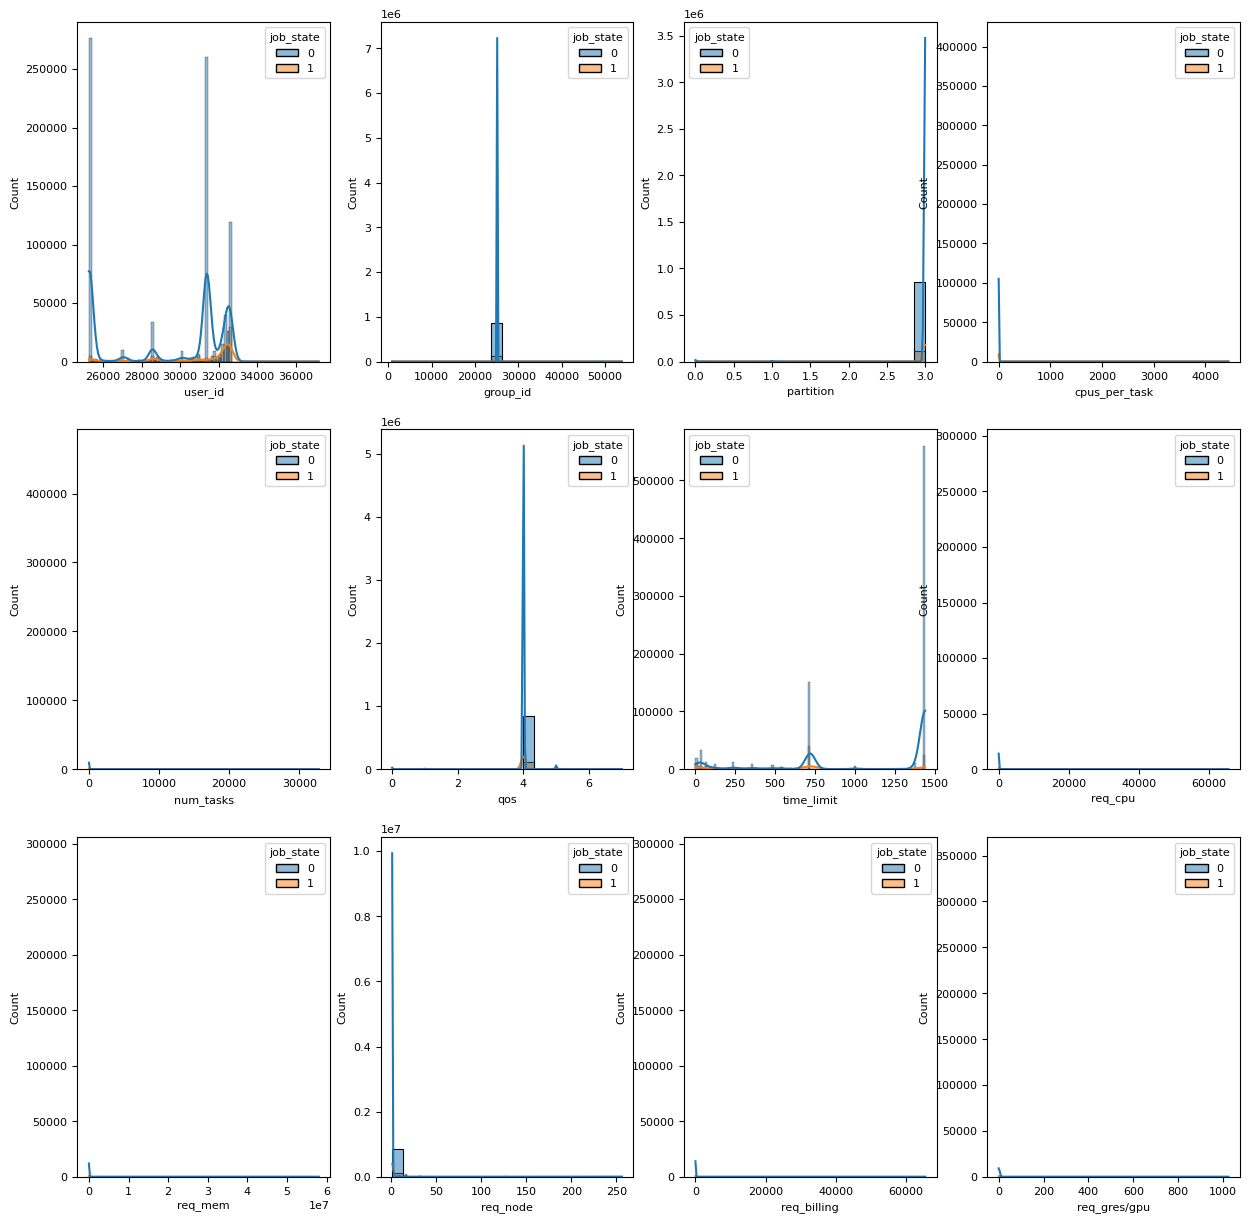

In [ ]:
print_col = set(df_bin.columns).difference(set(["command", "job_state", "name", "priority"]))
fig, axs = plt.subplots(3, 4, figsize=(15, 15))

sns.histplot(data=df_bin, x="user_id", hue="job_state", kde=True, color="skyblue", ax=axs[0, 0])
sns.histplot(data=df_bin, x="group_id", hue="job_state", kde=True, color="skyblue", ax=axs[0, 1])
sns.histplot(data=df_bin, x="partition", hue="job_state", kde=True, color="skyblue", ax=axs[0, 2])
sns.histplot(data=df_bin, x="cpus_per_task", hue="job_state", kde=True, color="skyblue", ax=axs[0, 3])
sns.histplot(data=df_bin, x="num_tasks", hue="job_state", kde=True, color="skyblue", ax=axs[1, 0])
sns.histplot(data=df_bin, x="qos", hue="job_state", kde=True, color="skyblue", ax=axs[1, 1])
sns.histplot(data=df_bin, x="time_limit", hue="job_state", kde=True, color="skyblue", ax=axs[1, 2])
sns.histplot(data=df_bin, x="req_cpu", hue="job_state", kde=True, color="skyblue", ax=axs[1, 3])
sns.histplot(data=df_bin, x="req_mem", hue="job_state", kde=True, color="skyblue", ax=axs[2, 0])
sns.histplot(data=df_bin, x="req_node", hue="job_state", kde=True, color="skyblue", ax=axs[2, 1])
sns.histplot(data=df_bin, x="req_billing", hue="job_state", kde=True, color="skyblue", ax=axs[2, 2])
sns.histplot(data=df_bin, x="req_gres/gpu", hue="job_state", kde=True, color="skyblue", ax=axs[2, 3])

# i, j = 0, 0
# for col in print_col:
#     sns.histplot(data=df_bin, x=col, hue="job_state", kde=True, color="skyblue", ax=axs[i, j])
#     j+=1
#     if j%4 == 0:
#         i+=1
#         j=0

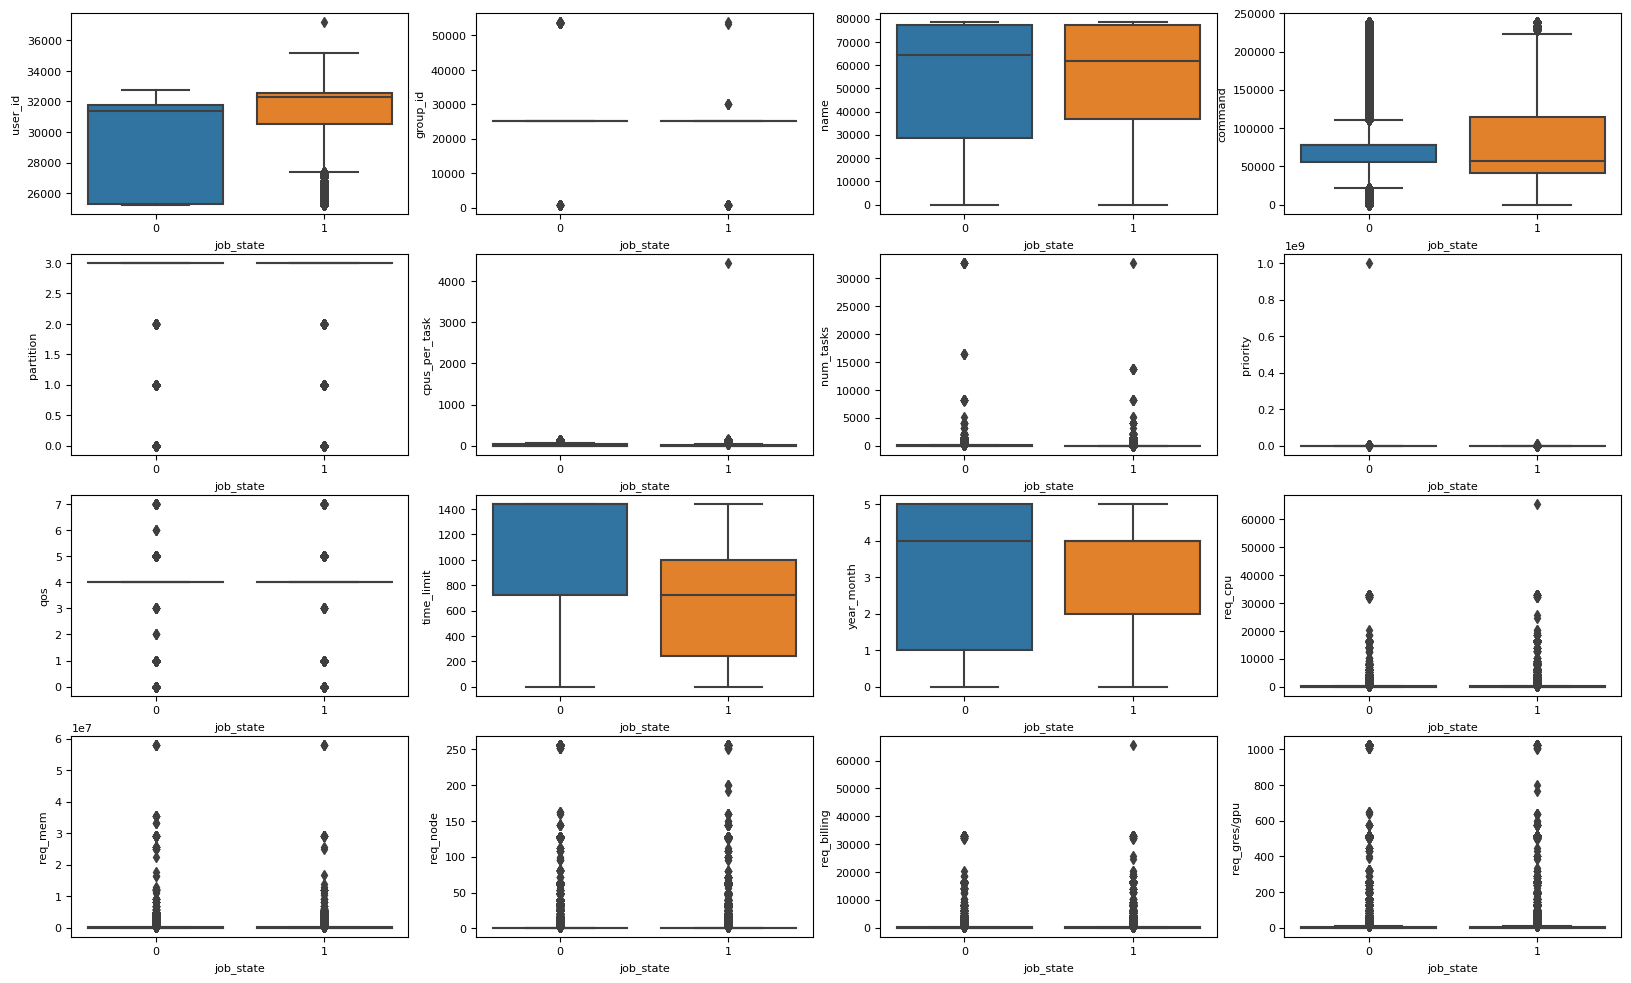

In [ ]:
fig, axs = plt.subplots(4, 4, figsize=(20, 12))

i, j = 0, 0
for col in df_bin.columns:
    if col != "job_state":
        sns.boxplot(x=df_bin["job_state"], y=df_bin[col], ax=axs[i, j])
        j+=1
        if j%4 == 0:
            i+=1
            j=0

## Exit state prediction

As first attempt we only consider 2 classes:
 - **0**: for completed job
 - **1**: for those failed
 
To do so, we firstly convert other failure classes into **FAILED**.

In [ ]:
def get_data(path):
    df = pd.read_pickle(path)
    labels = df["job_state"]
    df = df.drop(["job_state"], axis=1)
    return df.to_numpy(), labels.to_numpy()

print("Loading data... ", end="")
data, labels = get_data("data/job_table_r_preproc.pkl")
print("Lodaded!")
print()
print("Old labels: ", np.unique(labels))

labels[labels == "OUT_OF_MEMORY"] = "FAILED"
labels[labels == "TIMEOUT"] = "FAILED"

print("New labels: ", list(np.unique(labels)))

Loading data... Lodaded!

Old labels:  ['COMPLETED' 'FAILED' 'OUT_OF_MEMORY' 'TIMEOUT']
New labels:  ['COMPLETED', 'FAILED']


Encode labels

In [ ]:
lab_enc = LabelEncoder()
lab_enc.fit(labels)
unique_labels = lab_enc.classes_
num_classes = len(unique_labels)

print(f"Old values: {labels[:5]}")
labels = lab_enc.transform(labels).astype(float)
print(f"New values: {labels[:5]}")

Old values: ['COMPLETED' 'COMPLETED' 'COMPLETED' 'FAILED' 'COMPLETED']
New values: [0. 0. 0. 1. 0.]


Split the data into train, validation and test sets and normalize using only train information

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(data, labels, train_size=0.7, random_state=seed)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=0.8, random_state=seed)

x_train_mean = x_train.mean()
x_train_std = x_train.std()
x_train = (x_train - x_train_mean) / x_train_std
x_val = (x_val - x_train_mean) / x_train_std
x_test = (x_test - x_train_mean) / x_train_std

print(f"train data shape: {x_train.shape}")
print(f"val data shape: {x_val.shape}")
print(f"test data shape: {x_test.shape}")
print(f"train labels shape: {len(y_train)}")
print(f"val labels shape: {len(y_val)}")
print(f"test labels shape: {len(y_test)}")

train data shape: (546095, 15)
val data shape: (136524, 15)
test data shape: (292551, 15)
train labels shape: 546095
val labels shape: 136524
test labels shape: 292551


### Using a NN

Build the model

In [ ]:
def build_mlp_model(input_shape, output_shape, hiddens):
    model_in = keras.Input(shape=input_shape)
    x = model_in
    for h in hiddens:
        x = keras.layers.Dense(h, activation='relu')(x)
    x = keras.layers.Dropout(0.2)(x)
    model_out = keras.layers.Dense(output_shape, activation="sigmoid")(x)
    model = keras.Model(model_in, model_out)
    return model

In [ ]:
class WeightBCE(keras.losses.Loss):
    def __init__(self, weights, from_logits=False,
                 reduction=keras.losses.Reduction.AUTO,
                 name='weighted_decay_bce'):
        super().__init__(reduction=reduction, name=name)
        self.weights = weights
        self.from_logits = from_logits

    def call(self, y_true, y_pred):
        weights_v = tf.where(tf.equal(y_true, 1), self.weights[1], self.weights[0])
        weights_v = tf.cast(weights_v, dtype=tf.float32)
        bce = keras.backend.binary_crossentropy(y_true, y_pred, from_logits=self.from_logits)
        loss = keras.backend.mean(tf.multiply(bce, weights_v))
        return loss

In [ ]:
weights = class_weight.compute_class_weight(class_weight='balanced',
                                            classes=np.unique(y_train),
                                            y=y_train)

model = build_mlp_model((None, x_train.shape[1], ), 1, hiddens=[256, 128, 256])
model.compile(loss=WeightBCE(weights),
              optimizer=keras.optimizers.Adam(), 
              metrics=["accuracy"])
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, None, 15)]        0         
                                                                 
 dense_22 (Dense)            (None, None, 256)         4096      
                                                                 
 dense_23 (Dense)            (None, None, 128)         32896     
                                                                 
 dense_24 (Dense)            (None, None, 256)         33024     
                                                                 
 dropout_6 (Dropout)         (None, None, 256)         0         
                                                                 
 dense_25 (Dense)            (None, None, 1)           257       
                                                                 
Total params: 70,273
Trainable params: 70,273
Non-trainable

In [ ]:
#callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(x_train, y_train, epochs=30, validation_split=0.2, batch_size=256, callbacks=[])
# model.save_weights("checkpoints/mlp_wbce.h5")

Epoch 1/30


2023-06-05 12:20:08.665347: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [436876]
	 [[{{node Placeholder/_11}}]]
2023-06-05 12:20:08.665631: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [436876]
	 [[{{node Placeholder/_11}}]]


1690/1707 [============================>.] - ETA: 0s - loss: 0.4313 - accuracy: 0.7003

2023-06-05 12:20:15.059207: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [109219]
	 [[{{node Placeholder/_11}}]]
2023-06-05 12:20:15.059438: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [109219]
	 [[{{node Placeholder/_11}}]]


1707/1707 [==============================] - 7s 3ms/step - loss: 0.4309 - accuracy: 0.7006 - val_loss: 0.3791 - val_accuracy: 0.7119
Epoch 2/30
1707/1707 [==============================] - 6s 3ms/step - loss: 0.3556 - accuracy: 0.7693 - val_loss: 0.3307 - val_accuracy: 0.7953
Epoch 3/30
1707/1707 [==============================] - 6s 3ms/step - loss: 0.3243 - accuracy: 0.7973 - val_loss: 0.3155 - val_accuracy: 0.7957
Epoch 4/30
1707/1707 [==============================] - 6s 3ms/step - loss: 0.3106 - accuracy: 0.8091 - val_loss: 0.3040 - val_accuracy: 0.8145
Epoch 5/30
1707/1707 [==============================] - 6s 3ms/step - loss: 0.3027 - accuracy: 0.8145 - val_loss: 0.3146 - val_accuracy: 0.8158
Epoch 6/30
1707/1707 [==============================] - 6s 3ms/step - loss: 0.2961 - accuracy: 0.8189 - val_loss: 0.2893 - val_accuracy: 0.8260
Epoch 7/30
1707/1707 [==============================] - 6s 3ms/step - loss: 0.2899 - accuracy: 0.8235 - val_loss: 0.2869 - val_accuracy: 0.8159
Epo

146/286 [==============>...............] - ETA: 0s

2023-06-05 12:30:20.853114: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [292551,15]
	 [[{{node Placeholder/_10}}]]
2023-06-05 12:30:20.853344: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [292551,15]
	 [[{{node Placeholder/_10}}]]


286/286 [==============================] - 0s 1ms/step
F1 on test set: 0.61
Recall on test set: 0.95
Precision on test set: 0.45



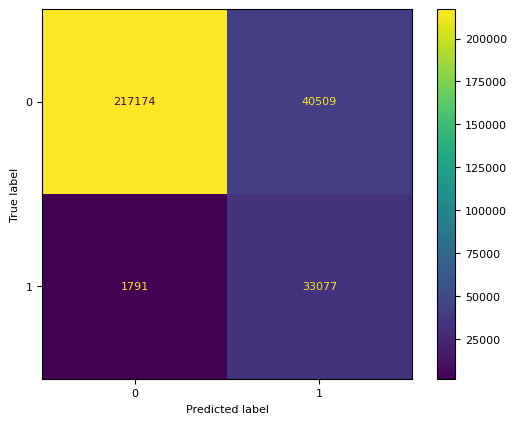

In [ ]:
# model.load_weights("checkpoints/tabMLP_wbce.h5")

y_pred = model.predict(x_test, batch_size=1024)
y_pred = tf.reshape(y_pred, y_pred.shape[0]).numpy()
y_pred = np.where(y_pred < 0.5, 0, 1)

# Create the confusion matrix
cm_nn = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm_nn).plot()

precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average="binary")
print(f"F1 on test set: {f1:.2f}")
print(f"Recall on test set: {recall:.2f}")
print(f"Precision on test set: {precision:.2f}")
print()

### Using Transformers

In [ ]:
data = pd.read_pickle("data/job_table_reduced.pkl")
labels = data["job_state"].to_numpy()
data = data.drop(["job_state"], axis=1)

labels[labels == "OUT_OF_MEMORY"] = "FAILED"
labels[labels == "TIMEOUT"] = "FAILED"

lab_enc = LabelEncoder()
lab_enc.fit(labels)
unique_labels = lab_enc.classes_
num_classes = len(unique_labels)

print(f"Old values: {labels[:5]}")
labels = lab_enc.transform(labels).astype(float)
print(f"New values: {labels[:5]}")


Old values: ['COMPLETED' 'COMPLETED' 'COMPLETED' 'FAILED' 'COMPLETED']
New values: [0. 0. 0. 1. 0.]


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(data, labels, train_size=0.7, random_state=seed)

print(f"train data shape: {x_train.shape}")
print(f"test data shape: {x_test.shape}")
print(f"train labels shape: {len(y_train)}")
print(f"test labels shape: {len(y_test)}")

y_train = y_train.astype(float)
y_test = y_test.astype(float)

categories = [
    len(x_train["name"].unique()),
    len(x_train["command"].unique()),
    len(x_train["partition"].unique()),
    len(x_train["qos"].unique())
]

train data shape: (682619, 17)
test data shape: (292551, 17)
train labels shape: 682619
test labels shape: 292551


In [ ]:
tabTransformer = TabTransformer(
    categories = categories, # number of unique elements in each categorical feature
    #num_continuous = 2,      # number of numerical features
    dim = 32,                # embedding/transformer dimension
    dim_out = 1,             # dimension of the model output
    depth = 6,               # number of transformer layers in the stack
    heads = 8,               # number of attention heads
    attn_dropout = 0.2,      # attention layer dropout in transformers
    ff_dropout = 0.2,        # feed-forward layer dropout in transformers
    mlp_hidden = [(68, 'relu'), (34, 'relu')] # mlp layer dimensions and activations
)

In [ ]:
weights = class_weight.compute_class_weight(class_weight='balanced',
                                            classes=np.unique(y_train),
                                            y=y_train)

tabTransformer.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.Adam(), 
              metrics=["accuracy"])

In [ ]:
cat_features  = ['name', 'command', 'partition', 'qos']
cont_features = ['user_id', 'group_id', 'cpus_per_task', 'num_cpus', 'num_nodes', 'num_tasks',
                 'priority', 'time_limit', 'req_cpu', 'req_mem', 'req_node', 'req_billing']

X = get_X_from_features(x_train, cont_features, cat_features)

history = tabTransformer.fit(X, y_train, epochs=30, validation_split=0.2, batch_size=256, callbacks=[])

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type int).

In [ ]:
import tensorflow_addons as tfa
from huggingface_hub import from_pretrained_keras

model = from_pretrained_keras("keras-io/tab_transformer")


/home/matteo/uni/aii/job_exit_state/.venv/lib/python3.8/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
config.json not found in HuggingFace Hub.


Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

In [ ]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.Adam(), 
              metrics=["accuracy"])

In [ ]:
history = model.fit(x_train, y_train, epochs=30, validation_split=0.2, batch_size=256, callbacks=[])

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type int).

### ML Approach

In [ ]:
# Create a random forest classifier
rf = RandomForestClassifier(random_state = seed)

rf.fit(x_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
y_pred = rf.predict(x_test)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average="binary")
print(f"F1 on test set: {f1}")
print(f"Recall on test set: {recall}")
print(f"Precision on test set: {precision}")

F1 on test set: 0.8443142430351107
Recall on test set: 0.8348342319605369
Precision on test set: 0.8540120287516503



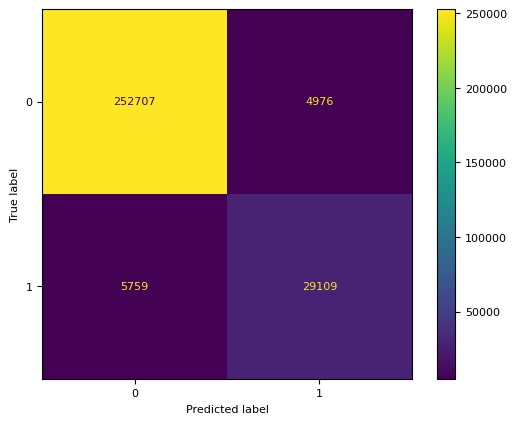

In [ ]:
# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

In [ ]:
import xgboost as xgb

model = xgb.XGBClassifier(objective='binary:logistic',
                          booster='gbtree',
                          max_depth=6,
                          scale_pos_weight=0.7,
                          eval_metric="logloss",
                          seed=seed,
                          eta=0.1)
model.fit(x_train, y_train)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.1, eval_metric='logloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

F1 on test set: 0.6632287161287936


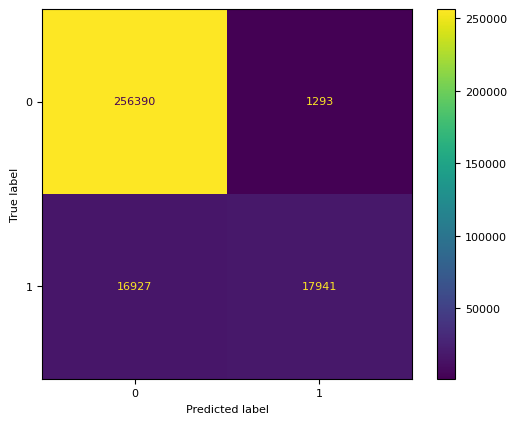

In [ ]:
y_pred = model.predict(x_test)
f1 = f1_score(y_test, y_pred)
print("F1 on test set:", f1)
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()